In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [3]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_HOTEL.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2007-1,969646,2007-01-01
1,2007-2,51237546,2007-02-01
2,2007-3,44745946,2007-03-01
3,2007-4,71632678,2007-04-01
4,2007-5,66687601,2007-05-01


In [4]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/restoran.json', 'w') as f:
    json.dump(json_data, f) 

{"2007-01-01T00:00:00.000":969646,"2007-02-01T00:00:00.000":51237546,"2007-03-01T00:00:00.000":44745946,"2007-04-01T00:00:00.000":71632678,"2007-05-01T00:00:00.000":66687601,"2007-06-01T00:00:00.000":89597411,"2007-07-01T00:00:00.000":65887461,"2007-08-01T00:00:00.000":83654840,"2007-09-01T00:00:00.000":76353701,"2007-10-01T00:00:00.000":80214360,"2007-11-01T00:00:00.000":80922262,"2007-12-01T00:00:00.000":73069860,"2008-01-01T00:00:00.000":106654840,"2008-02-01T00:00:00.000":40048620,"2008-03-01T00:00:00.000":39463500,"2008-04-01T00:00:00.000":77160120,"2008-05-01T00:00:00.000":84685164,"2008-06-01T00:00:00.000":94931221,"2008-07-01T00:00:00.000":141630123,"2008-08-01T00:00:00.000":77472200,"2008-09-01T00:00:00.000":110731300,"2008-10-01T00:00:00.000":129620400,"2008-11-01T00:00:00.000":112973200,"2008-12-01T00:00:00.000":69656400,"2009-01-01T00:00:00.000":180725980,"2009-02-01T00:00:00.000":180175800,"2009-03-01T00:00:00.000":123729800,"2009-04-01T00:00:00.000":103011414,"2009-05-01T

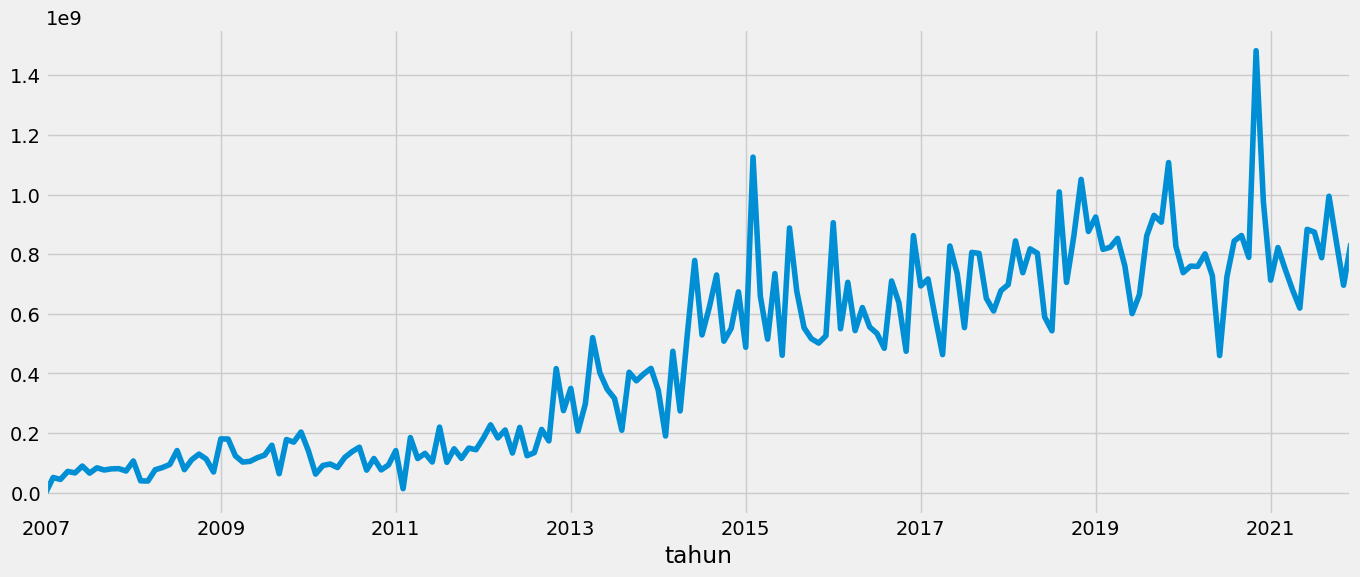

In [4]:
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [5]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 3
p = d = q = range(0, 3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 47806.188305223965
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 7130.256180934119
ARIMA(0, 0, 0) x (0, 0, 2, 12) - AIC: 6635.900483917245
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 6834.871480388493
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 6348.6608409449855
ARIMA(0, 0, 0) x (0, 1, 2, 12) - AIC: 5869.90444886966
ARIMA(0, 0, 0) x (0, 2, 0, 12) - AIC: 469714014371162.06
ARIMA(0, 0, 0) x (0, 2, 1, 12) - AIC: 5901.463322883302
ARIMA(0, 0, 0) x (0, 2, 2, 12) - AIC: 5423.269284065644
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC: 6876.134980581124
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC: 6821.177013715189
ARIMA(0, 0, 0) x (1, 0, 2, 12) - AIC: 6346.84018587947
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC: 6386.32331125911
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC: 6348.839123758588
ARIMA(0, 0, 0) x (1, 1, 2, 12) - AIC: 5866.595435386885
ARIMA(0, 0, 0) x (1, 2, 0, 12) - AIC: 5967.131481914745
ARIMA(0, 0, 0) x (1, 2, 1, 12) - AIC: 5878.915247236451
ARIMA(0, 0, 0) x (1, 2, 2, 12) - AIC: 5395.29196

# Plot model diagnostics

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True,)

results = mod.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3384.937
Date:                            Wed, 28 Dec 2022   AIC                           6777.873
Time:                                    08:21:24   BIC                           6790.345
Sample:                                01-01-2007   HQIC                          6782.935
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0335      0.181      0.184      0.854      -0.322       0.389
ma.L1         -0.8430      0.086   

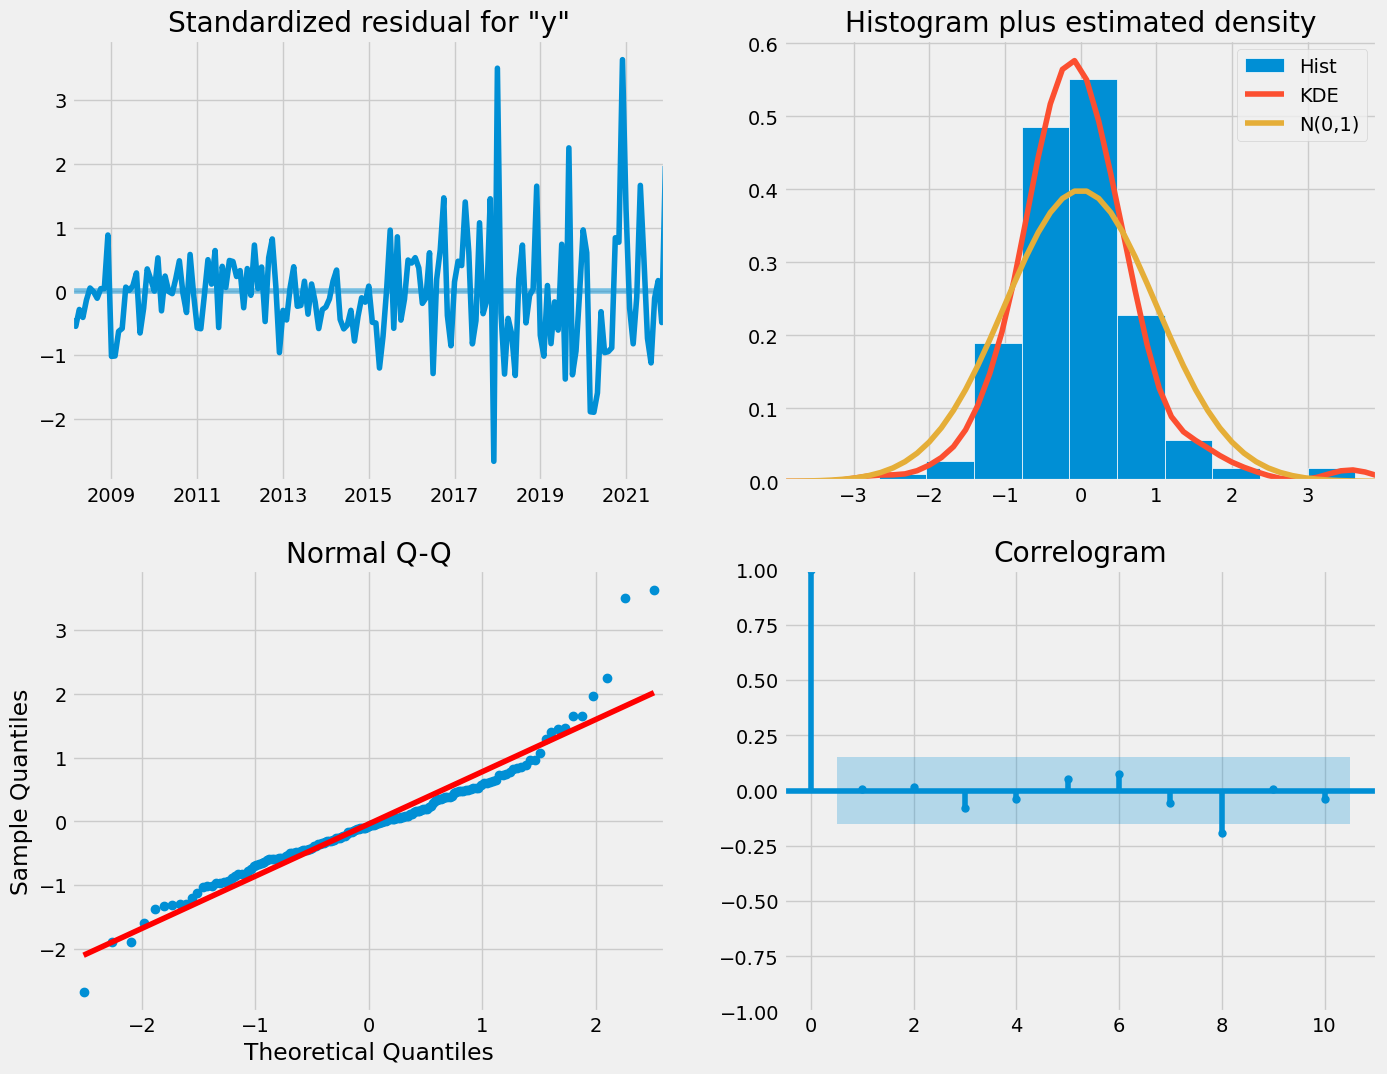

In [188]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [189]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()

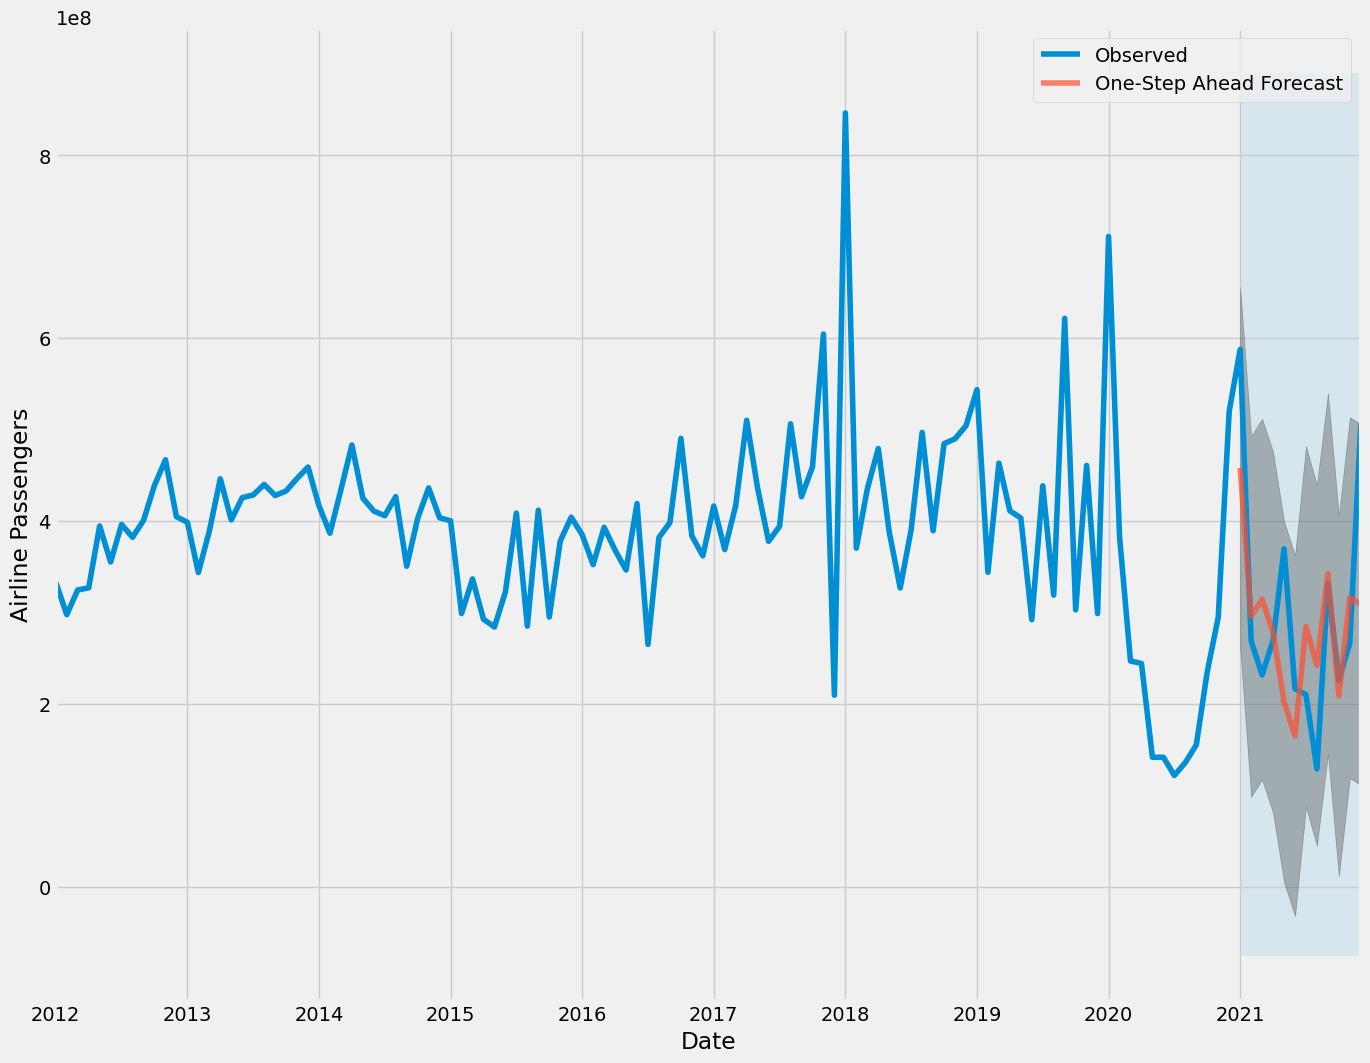

In [190]:
ax = dts['2010':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='One-Step Ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')
plt.legend()

plt.show()

In [ ]:
# Extract the predicted and true values of our time series
y_forecasted = pred.predicted_mean
y_truth = dts['2020-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error forecasts adalah {}'.format(round(mse, 2)))

In [ ]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [ ]:
ax = dts['2010':].plot(label='Observed', figsize=(15, 12))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Airline Passengers')

plt.legend()
plt.show()

# Prediksi data selama 2 tahun

In [11]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=60)
# Dapatkan interval
pred_ci = pred_uc.conf_int()


json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/restoran_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2022-01-01T00:00:00.000":809502852.4174873829,"2022-02-01T00:00:00.000":834878700.1637166739,"2022-03-01T00:00:00.000":802037740.1630702019,"2022-04-01T00:00:00.000":777352543.0896954536,"2022-05-01T00:00:00.000":790953164.900742054,"2022-06-01T00:00:00.000":743712229.0298480988,"2022-07-01T00:00:00.000":783842265.1050058603,"2022-08-01T00:00:00.000":863917404.3164401054,"2022-09-01T00:00:00.000":906657572.2164422274,"2022-10-01T00:00:00.000":848374095.4544663429,"2022-11-01T00:00:00.000":970873411.5505005121,"2022-12-01T00:00:00.000":897090230.50218606,"2023-01-01T00:00:00.000":846843725.7716323137,"2023-02-01T00:00:00.000":871440422.5385929346,"2023-03-01T00:00:00.000":838573399.4378480911,"2023-04-01T00:00:00.000":813887330.537055254,"2023-05-01T00:00:00.000":827487923.1849153042,"2023-06-01T00:00:00.000":780246986.3384940624,"2023-07-01T00:00:00.000":820377022.3810197115,"2023-08-01T00:00:00.000":900452161.5913624763,"2023-09-01T00:00:00.000":943192329.491328001,"2023-10-01T00:00

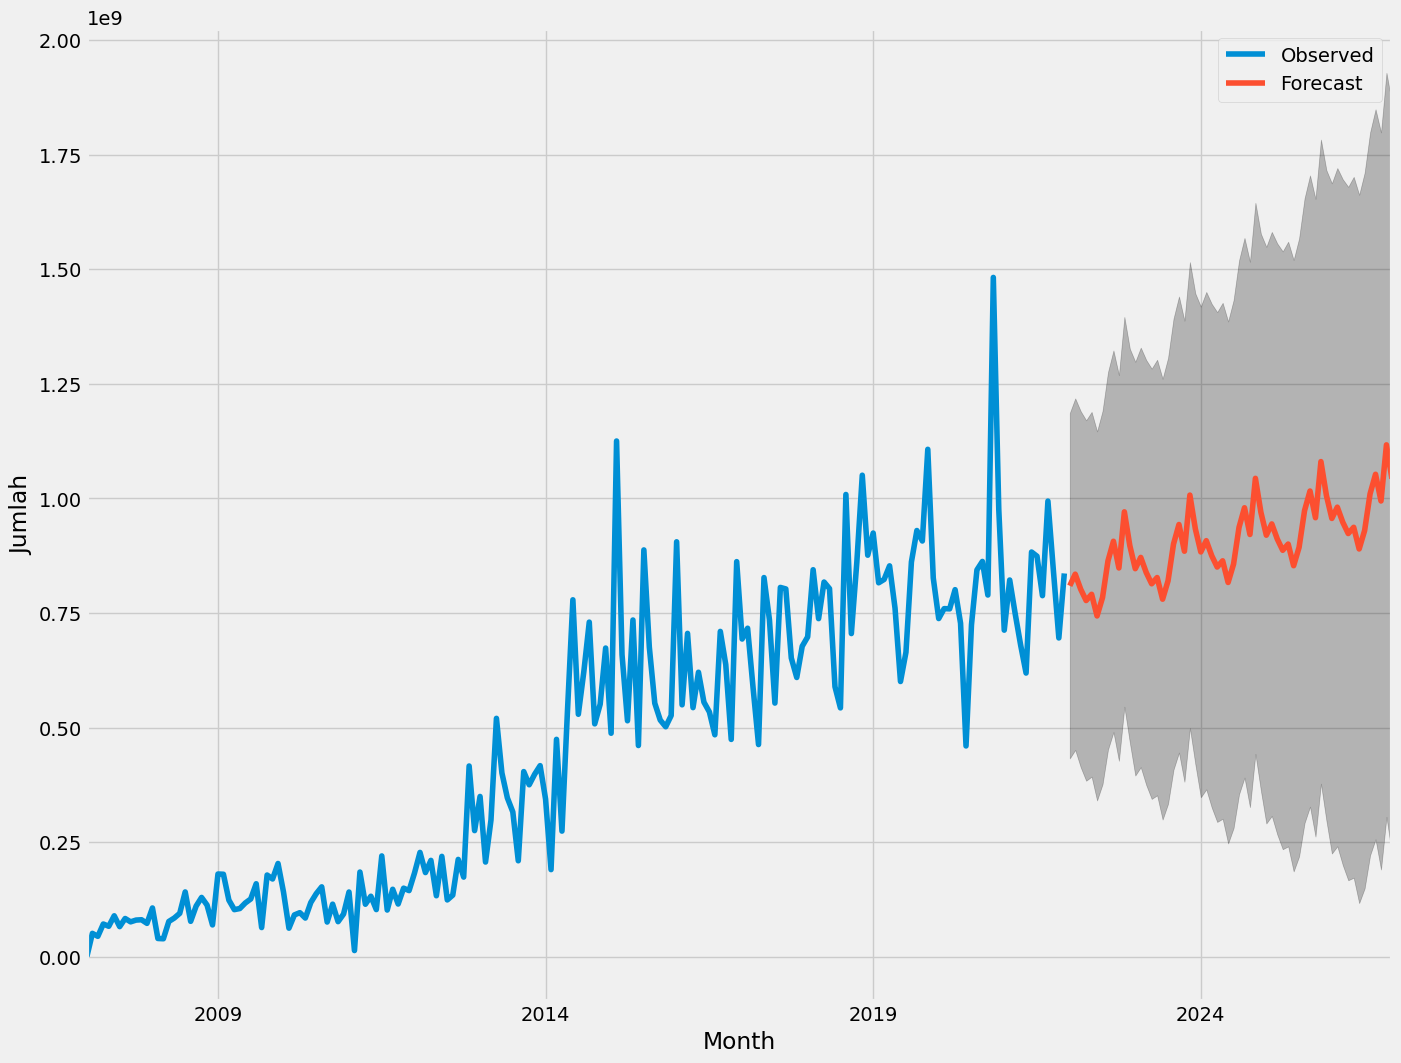

In [12]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')

plt.legend()
plt.show()